# EDA and model building for Titanic on Kaggle

In [1]:
import sys
sys.path.append("..")
import os
os.environ["MKL_NUM_THREADS"] = "3" # "6"
os.environ["OMP_NUM_THREADS"] = "2" # "4"
os.environ["NUMEXPR_NUM_THREADS"] = "3" # "6"
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from scripts.function_test import set_GPU

set_GPU(1)

def ShowDataGraph(data_frame):

    colors = ["Red", "Green", "Blue", "Orange", "Gold", "Darkseagreen"]

    len_columns = len(data_frame.columns)

    columns_name = list(data_frame.columns)

    fig = make_subplots(rows=len_columns//2 + 1, cols=2, subplot_titles=tuple(columns_name))
    current_col = 1

    for i in columns_name:
        if data_frame[i].dtype == "object":
            fig.add_trace(go.Bar(x=list(dict(data_frame[i].value_counts(sort=False)).keys()) ,y=list(dict(data_frame[i].value_counts(sort=False)).values()) ), row=columns_name.index(i) //2 + 1 , col=current_col)
        
        else:
            fig.add_trace(go.Histogram(x=list(data_frame[i])), row=columns_name.index(i) //2 + 1 , col=current_col)
        current_col = current_col + 1 if current_col < 2 else 1
            
    fig.update_layout(height=200 * len_columns// 2 , width= 900 ,title="Feature values",template="plotly_white", showlegend=False)
    
    fig.show()

def showFeatureImportant(X_frame, y, target_names=["Dead", "Survived"]):
    x = X_frame.unique()
    y_list = []
    unique_list = []
    
    for x_value in x:
        indexList = X_frame.index[X_frame == x_value]
        Target = y.loc[indexList.tolist()]
        values, counts = np.unique(Target, return_counts=True)

        if len(values) == len(target_names):
            unique_list.append(values)
            y_list.append(counts)
        
        else:
            counts_temp = np.zeros((2,), dtype='int64')
            counts_temp[values] = counts
            unique_list.append(np.array([i for i in range(len(target_names))], dtype='int64'))
            y_list.append(counts_temp)

    y_show = [[y_list[i][value] for i in range(len(y_list))] for value in range(len(target_names))]

    fig = go.Figure()
    for i in range(len(target_names)):
        fig.add_trace(go.Bar(x=x , y=y_show[i], name=target_names[i]))

    fig.update_layout(barmode='stack')
    fig.show()

def showFeatureDistribute(X_frame, showing_features, y, plot_mode=2):
    
    y_show = y.copy()

    data_show = pd.concat([X_frame, y_show], axis=1)

    data_show[y.name] = ["Yes" if value==1 else "No" for value in data_show[y.name]]

    if plot_mode == 2: 
        assert len(showing_features) == 2
        fig = px.scatter(data_show, x=showing_features[0], y=showing_features[1], color=str(y.name))

        fig.update_traces(marker=dict(size=12,
                                line=dict(width=2,
                                            color='DarkSlateGrey')),
                    selector=dict(mode='markers'))
        fig.update_layout(hovermode="x")
    else:
        assert len(showing_features) == 3
        fig = px.scatter_3d(data_show, x=showing_features[0], y=showing_features[1], z=showing_features[2], color=y.name, symbol=y.name)

    fig.show()


def make_mi_score(X, y):
    from sklearn.feature_selection import mutual_info_classif
    X = X.copy()
    X.dropna(axis=1, inplace=True)
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    return mi_scores

[INFO] ***********************************************
[INFO] You are using GPU(s): 0
[INFO] ***********************************************


# Load data

In [92]:
train_path = r"D:\Coding_practice\_Data\titanic\train.csv"
X_full = pd.read_csv(train_path, index_col='PassengerId')

test_path = r"D:\Coding_practice\_Data\titanic\test.csv"
submission_test = pd.read_csv(test_path, index_col='PassengerId')

## Simple preprocess
### - Drop NA columns
### - Drop y value

In [93]:
y_column = "Survived"

X_train_full = X_full.copy()
X_test_full = submission_test.copy()

# X_train_full.dropna(axis=1, inplace=True, thresh=len(X_full)//4)
# X_test.dropna(axis=1, inplace=True, thresh=len(X_test_full)//4)

y = X_train_full[y_column]
# X_train_full.drop([y_column], axis=1, inplace=True)
print("Done")
print(f"Numerical columns: {len([cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64','float64']])}")
print(f"Categorical columns: {len([cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['object']])}")

Done
Numerical columns: 6
Categorical columns: 5


# Data Visualization

In [25]:
X_visualize = X_train_full.copy()
X_visualize.drop(columns=["Cabin"], inplace=True)
X_visualize.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 76.6+ KB


In [22]:
X_visualize[["Sex", "Survived"]].groupby(['Sex'], as_index=False)['Survived'].mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [27]:
X_visualize[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


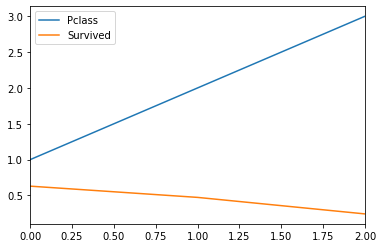

In [28]:
X_visualize[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False).plot()

In [23]:
X_visualize.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      2
dtype: int64

- ### Preprocess
    - [x] Imputation (for numerical value) 
        - Mean imputation
    - [ ] Handle categorical variables (Label encoding / One-hot encoding)
    - [ ] Handle outlier
    - [ ] Consider remove leakage data
- ### Building model
    - [ ] Simple Random Forest
    - [ ] Build Ensemble model

### Checking imputation method

In [29]:
## Using simple Random Forest Regressor as base model to evaluate the preprocess methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

def method_evaluate(X, y, method_formulas, method_names, list_estimator, list_random_state):
    assert len(method_formulas) == len(method_names)
    results = []

    for random_state in list_random_state:
        print(f"Running state: {random_state}")

        for n_estimator in list_estimator:
            method_scores = []
            classifier = RandomForestClassifier(n_estimators=n_estimator, random_state=random_state)

            print(f"The number of trees in the forest: {n_estimator}")
            
            for method in method_formulas:
                estimator = make_pipeline(method, classifier)

                ## Depend on problem and approach road to to choose "scoring"
                method_score = cross_val_score(estimator, X, y, scoring="accuracy", cv=5)
                method_scores.append(method_score.mean())

            results.append(np.argmin(np.array(method_scores)))
            print("-"*20)

    unique_results = list(dict.fromkeys(results))
    duplicate_unique = [results.count(i) for i in unique_results]
    best_method = unique_results[np.argmax(np.array(duplicate_unique))]

    print(f"{method_names[best_method]} is the best method with {max(duplicate_unique)} time max on {len(list_random_state) * len(list_estimator)}")

## Handle outlier for numerical variables
def handle_outlier(data_frame):
    numeric_cols = [cname for cname in data_frame.columns if data_frame[cname].dtype in ['int64', 'float64']]
    df_ = data_frame.copy()

    for cname in numeric_cols:
        if len(df_[cname].unique()) > 100:
            upper_lim = df_[cname].quantile(.95)
            lower_lim = df_[cname].quantile(.05)

            df_.loc[(df_[cname] > upper_lim), cname] = upper_lim
            df_.loc[(df_[cname] < lower_lim), cname] = lower_lim
    return df_

## Get mean and standard deviation of everypoint per columns
def get_mean_n_std(data_frame):
    col_names = [cname for cname in data_frame.columns]
    mean_n_std_df = pd.DataFrame()

    for cname in col_names:
        mean, std = data_frame[cname].mean(), data_frame[cname].std()
        mean_n_std_df[cname] = [mean, std]

    return mean_n_std_df

## Standarize data point every columns in dataframe
def get_z_score(data_frame, mean_n_std_frame, limit_unique=20):
    assert len(data_frame.columns) == len(mean_n_std_frame.columns)

    col_names = [cname for cname in data_frame.columns]

    standarize_df = data_frame.copy()

    for cname in col_names:
        
        if len(standarize_df[cname].unique()) > limit_unique:
            standarize_df[cname] = (standarize_df[cname] - mean_n_std_frame[cname][0]) / mean_n_std_frame[cname][1]

    return standarize_df


## Basic preprocess

In [55]:
def Titanic_preprocess(train_data, test_data):
    list_df = [train_data.copy(), test_data.copy()]
    ##
    ## Get feature Name and Title
    def replace_titles(x):
        title=x['Title']
        if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col','Sir']:
            return 'Mr'
        elif title in ['Countess', 'Mme', 'the Countess', "Dona"]:
            return 'Mrs'
        elif title in ['Mlle', 'Ms', 'Lady']:
            return 'Miss'
        elif title =='Dr':
            if x['Sex']=='Male':
                return 'Mr'
            else:
                return 'Mrs'
        else:
            return title

    for i in range(len(list_df)):
        X_train_testing = list_df[i].copy()
        df_test = pd.DataFrame()
        df_test[['Name1','Name2']] = X_train_testing["Name"].str.split(',', 1, expand=True)
        df_test[['Name2','Name3']] = df_test["Name2"].str.split(".",1, expand=True)
        ## Remove first space from "Name2" and "Name3" field
        df_test["Name2"] = df_test["Name2"].str.strip()
        df_test["Name3"] = df_test["Name3"].str.strip()
        list_df[i].drop(columns=['Name'], inplace=True)
        list_df[i]["FName"] = df_test["Name1"]
        # X_train_full["LName"] = df_test["Name3"]
        list_df[i]["Title"] = df_test["Name2"]
        list_df[i]["Title"] = list_df[i].apply(replace_titles, axis=1)

    ## Working with Age grouping
    for i in range(len(list_df)):
        list_df[i] = age_grouping(list_df[i], label="Age", relative_field="Title", test=True if i == 1 else False)

    ## Turning "Cabin" to "Desk"
    def substrings_in_string(big_string, substrings):
        for substring in substrings:
            if str.find(big_string, substring) != -1:
                return substring
        # print(big_string)
        return "0Unknown"

    cabin_list = ['0Unknown', 'A','B', 'C', 'D', 'E', 'F', 'T', 'G']

    for i in range(len(list_df)):
        list_df[i]['Deck']=list_df[i]['Cabin'].astype(str).map(lambda x: substrings_in_string(x, cabin_list))
        list_df[i].drop(columns='Cabin', inplace=True)

    ## Drop "Ticket"
    for i in range(len(list_df)):
        list_df[i].drop(columns=['Ticket'], inplace=True)

    ## Drop "Embarked"
    for i in range(len(list_df)):
        list_df[i].drop(columns=['Embarked'], inplace=True)

    ## Drop "Title"
    # for i in range(len(list_df)):
    #     list_df[i].drop(columns=['Title'], inplace=True)

    ## Create 'MPriority from 'Fare' and 'Pclass'
    list_df[0].dropna(axis=0, subset=["Fare"], inplace=True)
    list_df[0].drop(list_df[0][list_df[0].Fare==0].index, inplace=True)
    list_df[1]["Fare"].fillna(0, inplace=True)

    # for i in range(len(list_df)):
    #     list_df
        
        # list_df[i]["MPriority"] = list_df[i]["Fare"] / list_df[i]["Pclass"]
        # # / list_df[i]["Pclass"] ** 3
        # list_df[i].drop(columns=["Fare"], inplace=True)
        # list_df[i].drop(columns=["Pclass"], inplace=True)

    return list_df[0], list_df[1]

## Remove outlier and grouping by value
def age_grouping(data_frame, label="Age", relative_field=" ", test=False, gr_range=[[0,10],[10, 20],[20,30],[30,40],[40,50],[50, 60], [60]]):

    # Remove outlier
    # if not test:
    #     index_rm_outlier = np.where((data_frame[label] > 1 ) & (data_frame[label] <70))
    #     return_df = data_frame.copy()
    #     return_df = return_df.iloc[index_rm_outlier]

    # else:
    new_label = "Age group"
    return_df = data_frame.copy()
    return_df.dropna(subset=[label], inplace=True)

    # Handle NA value by using a field have relative information
    nan_df = data_frame.copy()
    naIndex = nan_df[label].isna()[lambda x:x].index
    nan_df = nan_df.loc[naIndex]
    nan_title = ['Mr','Mrs','Miss','Master']
    nan_range = [3,     3,     2,      2]
    
    nan_df[new_label] = nan_df[label]
    return_df[new_label] = return_df[label]

    for title in nan_title:
        index = np.where(nan_df[relative_field] == title)
        nan_df[new_label].iloc[index] = nan_range[nan_title.index(title)]

    for group in gr_range:
        if len(group) > 1:
            index = np.where(
                (return_df[label] >= group[0] ) & (return_df[label] <= group[1])
                )
            return_df[new_label].iloc[index] = gr_range.index(group) + 1

        else:
            if gr_range.index(group) == len(gr_range) - 1:
                index = np.where(return_df[label] > group[0])
            
            else:
                index = np.where(return_df[label] < group[0])

            return_df[new_label].iloc[index] = gr_range.index(group) + 1

    return_df = pd.concat([return_df, nan_df], axis=0)
    return_df.sort_index(inplace=True, axis=0)
    return_df[new_label] = return_df[new_label].astype(int)
    return_df.drop(columns=[label], inplace=True)

    return return_df

## Only use this after basic preprocess
def get_Familysize(train_data, test_data):
    fields = ["FName", "SibSp", "Parch"]

    dt_addon = pd.DataFrame()
    
    train_data_pp = train_data.copy()
    test_data_pp = test_data.copy()

    list_df = [train_data.copy(), test_data.copy()]
    for j in range(len(list_df)):
        list_df[j]["FamilySize"] = [list_df[j][fields[1]].iloc[i] + list_df[j][fields[2]].iloc[i] + 1 for i in range(len(list_df[j]))]

        for k in fields:
            # if k == "FName":
            #     continue
            # else:
            #     pass
            list_df[j].drop(columns=[k], inplace=True)

    return list_df[0], list_df[1]


def get_combination_fied(train_data, test_data):
    list_df = [train_data.copy(), test_data.copy()]
    list_temp = [train_data.copy(), test_data.copy()]
    relative_labels = ["Fare", "FamilySize", "Pclass", "Sex", "Age", "Deck"]

    """
    Pclass  Sex  Age  Deck  MPriority  Relative
    """

    for i in range(len(list_temp)):
        list_temp[i]["Pclass"] = [np.log(float("1e" + str(int(len(list_df[i]["Pclass"].unique()) - list_temp[i]["Pclass"].iloc[j]))) + 1) for j in range(len(list_temp[i]["Pclass"]))]

    for i in range(len(list_temp)):
        list_temp[i]["Age"] = [ np.log(float("1e" + str(int(len(list_df[i]["Age"].unique())))) + 1) / list_df[i]["Age"].value_counts(normalize=True)[list_df[i]["Age"].iloc[j]]  for j in range(len(list_temp[i]["Age"])) ]

    for i in range(len(list_temp)):
        list_temp[i]["Sex"] = [np.log(float("1e" + str(int(1 - list_df[i]["Sex"].iloc[j] ))) + 1) / list_df[i]["Sex"].value_counts(normalize=True)[list_df[i]["Sex"].iloc[j]] for j in range(len(list_temp[i]["Sex"])) ]

    for i in range(len(list_temp)):
        list_temp[i]["FamilySize"] = [np.log(float("1e" + str(int(value))) + 1) for value in list_temp[i]["FamilySize"].values]

    for i in range(len(list_temp)):
        list_temp[i]["Deck"] = [np.log(float("1e" + str(int(value))) + 1) for value in list_temp[i]["Deck"].values]

    for i in range(len(list_df)):
        list_df[i]["SexPclass"] = [ list_temp[i]["Sex"].iloc[j] * list_temp[i]["Pclass"].iloc[j] * list_temp[i]["Age"].iloc[j] for j in range(len(list_temp[i]["Sex"])) ]
        # / list_df[i]["Age"].value_counts(normalize=True)[list_df[i]["Age"].iloc[j]]

        # Sex = 0 -> 1e1 , Sex = 1 -> 1e0

    ## Deck - Pclass condition
    ## Use for second condition
    ## Need to use long
    for i in range(len(list_df)):
        list_df[i]["DeckPclass"] = [list_temp[i]["Deck"].iloc[j] * list_temp[i]["Pclass"].iloc[j]  for j in range(len(list_temp[i]["Deck"]))]
    
    ## Sex - Age condition
    ## Use for second condition
    ## Don't need to use log
    for i in range(len(list_df)):
        list_df[i]["SexAge"] = [list_temp[i]["Sex"].iloc[j] * list_temp[i]["Age"].iloc[j]  for j in range(len(list_temp[i]["Age"]))]
    # * list_temp[i]["Pclass"].iloc[j]

    ## Age - Relative condition
    ## Use for second condition
    ## Don't need to use log
    for i in range(len(list_df)):
        list_df[i]["FamilySizeSex"] = [list_temp[i]["FamilySize"].iloc[j] * list_temp[i]["Sex"].iloc[j]  for j in range(len(list_temp[i]["Relative"]))]

    ## Combined field
    ## First condition
    for i in range(len(list_df)):
        list_df[i]["MPriority"] = [np.log(list_df[i]["Fare"].iloc[j] + 1) * list_temp[i]["Pclass"].iloc[j] * list_temp[i]["Sex"].iloc[j] for j in range(len(list_df[i]["Fare"]))]

        for j in range(len(relative_labels)):
            list_df[i].drop(columns=[relative_labels[j]], inplace=True)

    return list_df[0], list_df[1]


def post_preprocess(train_data, test_data, limit_unique=20, n_components=3):
    list_df = [train_data.copy(), test_data.copy()]
    list_df[0], list_df[1] = get_Familysize(list_df[0], list_df[1])

    # list_df[0], list_df[1] = get_combination_fied(list_df[0], list_df[1])
    
    # list_df[0], list_df[1] = scaling_data(list_df[0], list_df[1], limit_unique=limit_unique)
    
    # list_df[0], list_df[1] = apply_pca(list_df[0], list_df[1], n_components)

    return list_df[0], list_df[1]

def scaling_data(train_data, test_data, limit_unique=20):

    from sklearn.preprocessing import StandardScaler
    z_scaler = StandardScaler()
    
    target_column = "Survived"
    features_data = train_data.copy()

    y_data = features_data[target_column]
    features_data.drop(columns=[target_column], inplace=True)

    mean_n_std = get_mean_n_std(features_data)
    train_data_scaled = get_z_score(features_data, mean_n_std, limit_unique=limit_unique)
    test_data_scaled = get_z_score(test_data, mean_n_std, limit_unique=limit_unique)

    train_data_scaled = pd.concat([train_data_scaled, y_data], axis=1)

    return train_data_scaled, test_data_scaled

def apply_pca(train_data, test_data, n_components=3):
    from sklearn.decomposition import PCA

    pca = PCA(n_components=n_components)
    target_column = "Survived"
    features_data = train_data.copy()

    y_data = features_data[target_column]
    features_data.drop(columns=[target_column], inplace=True)

    X_train_PCA = pca.fit_transform(features_data)
    X_test_PCA = pca.transform(test_data)

    component_names = [f"PC{i+1}" for i in range(X_train_PCA.shape[1])]
    train_pca = pd.DataFrame(X_train_PCA, columns=component_names, index=train_data.index)
    test_pca = pd.DataFrame(X_test_PCA, columns=component_names, index=test_data.index)

    train_pca = pd.concat([train_pca, y_data], axis=1)

    return train_pca, test_pca

In [31]:
## Handle numerical data
def preprocess_numerical_data(train_data, test_data, ignore_lables=[], limit_unique=10):

    assert list(train_data.columns) == list(test_data.columns)
    numerical_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64','float64']]

    numerical_cols = list(set(numerical_cols) - set(ignore_lables))
    X_train = train_data[numerical_cols].copy()
    X_test = test_data[numerical_cols].copy()

    ## Imputation
    imputation = SimpleImputer(strategy="mean")
    imputed_X_train = pd.DataFrame(imputation.fit_transform(X_train), index=pd.RangeIndex(start=min(X_train.index), stop=max(X_train.index) + 1))

    imputed_X_test = pd.DataFrame(imputation.transform(X_test), index=pd.RangeIndex(start=min(X_test.index), stop=max(X_test.index) + 1))

    imputed_X_train.columns = X_train.columns
    imputed_X_test.columns = X_test.columns

    ## Outlier
    outlier_X_train = handle_outlier(imputed_X_train)
    outlier_X_test = handle_outlier(imputed_X_test)

    ## Scaling
    mean_n_std_df = get_mean_n_std(outlier_X_train)
    scaled_X_train = get_z_score(outlier_X_train, mean_n_std_df, limit_unique=limit_unique)
    scaled_X_test = get_z_score(outlier_X_test, mean_n_std_df, limit_unique=limit_unique)

    train_data_frame = train_data.copy()
    test_data_frame = test_data.copy()

    train_data_frame[numerical_cols] = scaled_X_train[numerical_cols]
    test_data_frame[numerical_cols] = scaled_X_test[numerical_cols]

    return train_data_frame, test_data_frame

## Handle categorical data
def preprocess_categorical_data(train_data_frame, test_data_frame, ignore_lables=[]):
    
    train_df = train_data_frame.copy()
    test_df = test_data_frame.copy()
    
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()

    categorical_cols = [cname for cname in train_data_frame.columns if train_data_frame[cname].dtype in ['object']]

    categorical_cols = list(set(categorical_cols) - set(ignore_lables))
    # Label encoding 
    for cname in categorical_cols:
        if train_df[cname].isna().values.any() or test_df[cname].isna().values.any():
            if cname == "Embarked":
                train_df.dropna( subset=[cname], inplace=True)
            train_df[cname] = train_df[cname].replace(np.nan, "NaN", regex=True)
            test_df[cname] = test_df[cname].replace(np.nan, "NaN", regex=True)
        
        print(cname)
        
        total_values = pd.concat([train_df[cname], test_df[cname]])
        le.fit(total_values)
        if len(list(le.classes_)) < 15:
            print(list(le.classes_))
        train_df[cname] = le.transform(train_df[cname])
        test_df[cname] = le.transform(test_df[cname])

    return train_df, test_df

In [94]:
ignore_labels = ["Age", "MPriority"]
# y = X_train_full.pop(y_coluWmn)
# X_train_numerical, X_test_numerical = preprocess_numerical_data(X_train_full, X_test, ignore_labels)
X_train_adp , X_test_adp = Titanic_preprocess(X_train_full, X_test_full)
X_train_t, X_test_t = post_preprocess(X_train_adp, X_test_adp, limit_unique=3)
# X_train_t.reset_index(drop=True)

In [96]:
X_train_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876 entries, 1 to 891
Data columns (total 8 columns):
Survived      876 non-null int64
Pclass        876 non-null int64
Sex           876 non-null object
Fare          876 non-null float64
Title         876 non-null object
Age group     876 non-null int32
Deck          876 non-null object
FamilySize    876 non-null int64
dtypes: float64(1), int32(1), int64(3), object(3)
memory usage: 58.2+ KB


In [108]:
X_train_t[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.644550
1,2,0.488764
2,3,0.242300


In [97]:
X_train_t[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.310345
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [54]:
X_train_t[['Deck', 'Survived']].groupby(['Deck'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Deck,Survived
2,B,0.777778
4,D,0.757576
5,E,0.757576
3,C,0.593220
6,F,0.583333
1,A,0.500000
7,G,0.500000
0,0Unknown,0.303704
8,T,0.000000


In [51]:
X_train_t.groupby("Age group")['Survived'].mean()

Age group
1    0.612903
2    0.460993
3    0.298851
4    0.445122
5    0.390805
6    0.423077
7    0.227273
Name: Survived, dtype: float64

## Advance preprocess

In [99]:
X_pp , X_test_pp = preprocess_categorical_data(X_train_adp, X_test_adp, ignore_labels)
train_t, test_t = post_preprocess(X_pp, X_test_pp, limit_unique=3)

train_t

Deck
['0Unknown', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
Sex
['female', 'male']
Title
['Master', 'Miss', 'Mr', 'Mrs']
FName


,Survived,Pclass,Sex,Fare,Title,Age group,Deck,FamilySize
PassengerId,,,,,,,,
1,0,3,1,7.2500,2,3,0,2
2,1,1,0,71.2833,3,4,3,2
3,1,3,0,7.9250,1,3,0,1
4,1,1,0,53.1000,3,4,3,2
5,0,3,1,8.0500,2,4,0,1
...,...,...,...,...,...,...,...,...
887,0,2,1,13.0000,2,3,0,1
888,1,1,0,30.0000,1,2,2,1
889,0,3,0,23.4500,1,2,0,4


In [72]:
train_t.head(10)

,Survived,Pclass,Sex,Fare,Title,Age group,Deck,FamilySize
PassengerId,,,,,,,,
1,0,3,1,7.2500,2,3,0,2
2,1,1,0,71.2833,3,4,3,2
3,1,3,0,7.9250,1,3,0,1
4,1,1,0,53.1000,3,4,3,2
5,0,3,1,8.0500,2,4,0,1
6,0,3,1,8.4583,2,3,0,1
7,0,1,1,51.8625,2,6,5,1
8,0,3,1,21.0750,0,1,0,5
9,1,3,0,11.1333,3,3,0,3


In [100]:
from sklearn.ensemble import RandomForestClassifier

X = train_t.drop('Survived', axis=1)
y = train_t.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [102]:
model = RandomForestClassifier(n_estimators=200)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [103]:
print("Train score:")
print(model.score(X_train, y_train))

print("Test score:")
print(model.score(X_test, y_test))

Train score:
0.9608482871125612
Test score:
0.8174904942965779


In [104]:
model.feature_importances_

array([0.08897353, 0.17625694, 0.31373921, 0.12789142, 0.11241844,
       0.08438358, 0.09633687])

In [105]:
coeff_df = pd.DataFrame(model.feature_importances_, X.columns, columns=['Coefficient'])
coeff_df.sort_values(by='Coefficient', ascending=False)

,Coefficient
Fare,0.313739
Sex,0.176257
Title,0.127891
Age group,0.112418
FamilySize,0.096337
Pclass,0.088974
Deck,0.084384


## Model evaluation
- ### [] Using Cross-Validation to choose parameters for model
    - Choose the best ensemble models
    - Tune the models with right hyper parameters
- ### [] Export submission file on Test data


In [78]:
from sklearn.model_selection import cross_validate, cross_val_score, ShuffleSplit
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn import metrics
from xgboost import XGBClassifier

In [80]:
y_t = train_t.pop("Survived")

In [81]:
X_train, X_valid, y_train, y_valid = train_test_split(train_t.to_numpy(), y_t.to_numpy(), test_size=0.2, random_state=42)

In [82]:

clf_xgb = XGBClassifier(max_depth=8,
learning_rate=0.1,
n_estimators=1000,
verbosity=0,
silent=None,
objective="binary:logistic",
booster='gbtree',
n_jobs=-1,
nthread=None,
gamma=0,
min_child_weight=1,
max_delta_step=0,
subsample=0.7,
colsample_bytree=1,
colsample_bylevel=1,
colsample_bynode=1,
reg_alpha=0,
reg_lambda=1,
scale_pos_weight=1,
base_score=0.5,
random_state=0,
seed=None,)

clf_xgb.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=200,
            verbose=10)

[0]	validation_0-error:0.23295
Will train until validation_0-error hasn't improved in 200 rounds.
[10]	validation_0-error:0.20455
[20]	validation_0-error:0.20455
[30]	validation_0-error:0.20455
[40]	validation_0-error:0.19886
[50]	validation_0-error:0.19886
[60]	validation_0-error:0.22727
[70]	validation_0-error:0.25568
[80]	validation_0-error:0.24432
[90]	validation_0-error:0.22727
[100]	validation_0-error:0.23864
[110]	validation_0-error:0.23295
[120]	validation_0-error:0.23295
[130]	validation_0-error:0.22159
[140]	validation_0-error:0.21591
[150]	validation_0-error:0.21023
[160]	validation_0-error:0.21023
[170]	validation_0-error:0.22159
[180]	validation_0-error:0.22727
[190]	validation_0-error:0.21591
[200]	validation_0-error:0.22727
[210]	validation_0-error:0.22727
Stopping. Best iteration:
[13]	validation_0-error:0.18750



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=0, silent=None, subsample=0.7, tree_method='exact',
              validate_parameters=1, verbosity=0)

In [85]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=5e-2),
    scheduler_params = {"gamma": 0.95,
                        "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

Device used : cuda


In [86]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=1000, patience=250,
    batch_size=256, virtual_batch_size=64
) 

lid_auc: 0.81915 |  0:00:49s
epoch 124| loss: 0.37548 | train_auc: 0.89727 | valid_auc: 0.85124 |  0:00:50s
epoch 125| loss: 0.36635 | train_auc: 0.90002 | valid_auc: 0.83958 |  0:00:50s
epoch 126| loss: 0.36796 | train_auc: 0.90245 | valid_auc: 0.83263 |  0:00:50s
epoch 127| loss: 0.37611 | train_auc: 0.90153 | valid_auc: 0.83052 |  0:00:51s
epoch 128| loss: 0.37033 | train_auc: 0.90062 | valid_auc: 0.83305 |  0:00:51s
epoch 129| loss: 0.36955 | train_auc: 0.9024  | valid_auc: 0.83944 |  0:00:51s
epoch 130| loss: 0.37269 | train_auc: 0.90231 | valid_auc: 0.8136  |  0:00:52s
epoch 131| loss: 0.37651 | train_auc: 0.90391 | valid_auc: 0.80601 |  0:00:52s
epoch 132| loss: 0.37775 | train_auc: 0.90246 | valid_auc: 0.81577 |  0:00:52s
epoch 133| loss: 0.37674 | train_auc: 0.89888 | valid_auc: 0.82982 |  0:00:53s
epoch 134| loss: 0.37422 | train_auc: 0.89861 | valid_auc: 0.82961 |  0:00:53s
epoch 135| loss: 0.36775 | train_auc: 0.90214 | valid_auc: 0.81325 |  0:00:53s
epoch 136| loss: 0.3662

In [87]:
preds_test = clf.predict(test_t.to_numpy())

output = pd.DataFrame({
    'PassengerId': test_t.index,
    'Survived': preds_test
})

output.to_csv('tabnet_.csv', index=False)